**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer

In [ ]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(3)

torch.backends.cudnn.benchmark=True

In [ ]:
# wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
PATH = Path('data/imagenet')
PATH_TRN = PATH/'train'

In [ ]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

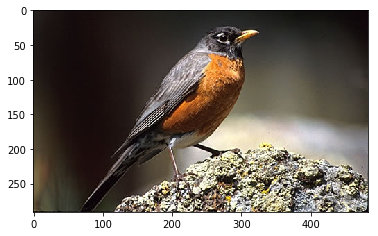

In [ ]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [ ]:
sz=288

In [ ]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

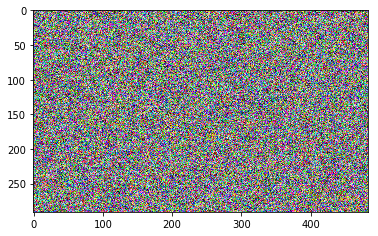

In [ ]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [ ]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

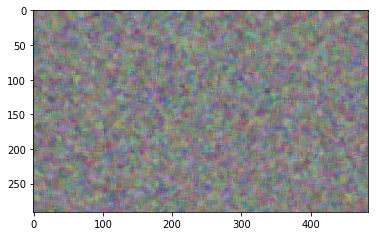

In [ ]:
plt.imshow(opt_img);

In [ ]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [ ]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [ ]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [ ]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [ ]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [ ]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.8466196656227112
Iteration: n_iter, loss: 0.34066855907440186
Iteration: n_iter, loss: 0.21001280844211578
Iteration: n_iter, loss: 0.15562333166599274
Iteration: n_iter, loss: 0.12673595547676086
Iteration: n_iter, loss: 0.10863320529460907
Iteration: n_iter, loss: 0.0966048613190651
Iteration: n_iter, loss: 0.08812198787927628
Iteration: n_iter, loss: 0.08170554041862488
Iteration: n_iter, loss: 0.07657770067453384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


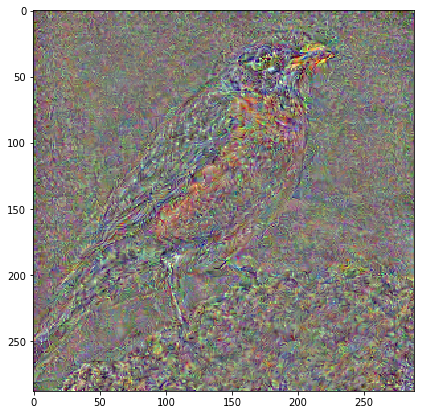

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [ ]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [ ]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [ ]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [ ]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [ ]:
opt_img_v, optimizer = get_opt()

In [ ]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [ ]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.2112911492586136
Iteration: n_iter, loss: 0.0902421623468399
Iteration: n_iter, loss: 0.05904778465628624
Iteration: n_iter, loss: 0.04517251253128052
Iteration: n_iter, loss: 0.03721420466899872
Iteration: n_iter, loss: 0.03215853497385979
Iteration: n_iter, loss: 0.028526008129119873
Iteration: n_iter, loss: 0.025799645110964775
Iteration: n_iter, loss: 0.02361033484339714
Iteration: n_iter, loss: 0.021835438907146454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


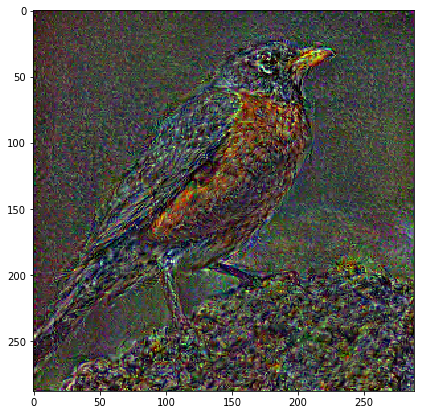

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [ ]:
sf.close()

## Style match

In [ ]:
# wget https://raw.githubusercontent.com/jeffxtang/fast-style-transfer/master/images/starry_night.jpg
style_fn = PATH/'style'/'starry_night.jpg'

In [ ]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1198, 1513, 3), (291, 483, 3))

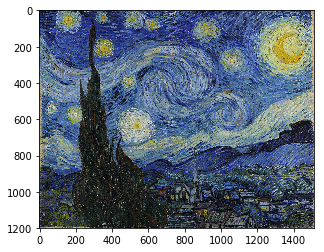

In [ ]:
plt.imshow(style_img);

In [ ]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [ ]:
style = scale_match(img, style_img)

((291, 483, 3), (291, 483, 3))

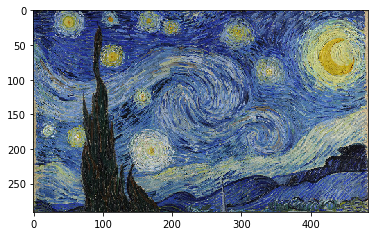

In [ ]:
plt.imshow(style)
style.shape, img.shape

In [ ]:
opt_img_v, optimizer = get_opt()

In [ ]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [ ]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [ ]:
style_tfm = val_tfms(style_img)

In [ ]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [ ]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [ ]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 230718.453125
Iteration: n_iter, loss: 219493.21875
Iteration: n_iter, loss: 202618.109375
Iteration: n_iter, loss: 481.5616760253906
Iteration: n_iter, loss: 147.41177368164062
Iteration: n_iter, loss: 80.62625122070312
Iteration: n_iter, loss: 49.52326965332031
Iteration: n_iter, loss: 32.36254119873047
Iteration: n_iter, loss: 21.831811904907227
Iteration: n_iter, loss: 15.61091423034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


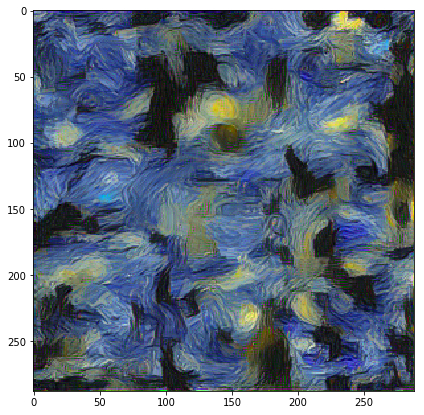

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [ ]:
for sf in sfs: sf.close()

## Style transfer

In [ ]:
opt_img_v, optimizer = get_opt()

In [ ]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [ ]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 1802.36767578125
Iteration: n_iter, loss: 1163.05908203125
Iteration: n_iter, loss: 961.6024169921875
Iteration: n_iter, loss: 853.079833984375
Iteration: n_iter, loss: 784.970458984375
Iteration: n_iter, loss: 739.18994140625
Iteration: n_iter, loss: 706.310791015625
Iteration: n_iter, loss: 681.6689453125
Iteration: n_iter, loss: 662.4088134765625
Iteration: n_iter, loss: 646.329833984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


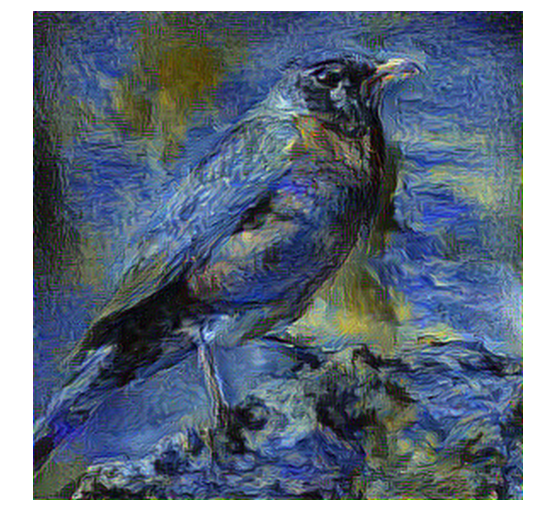

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [ ]:
for sf in sfs: sf.close()